<a href="https://colab.research.google.com/github/jioffe502/peptide/blob/main/peptideQSAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy  as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

# upload dataset
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving DPPS_descriptor.xlsx to DPPS_descriptor.xlsx
User uploaded file "DPPS_descriptor.xlsx" with length 11775 bytes


In [ ]:
from google.colab import files

# upload dataset
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data_peptide.csv to data_peptide.csv
User uploaded file "data_peptide.csv" with length 2436 bytes


In [ ]:
############# FIRST ITERATION ####################

In [2]:
###### Part1 Process the Data
DataTable = pd.read_excel(r'/content/DPPS_descriptor.xlsx')
DataTable = DataTable.values                   # change DataFrame into Array
     

In [3]:
def DataChoice(str1):
    '''
    define the function for generating the updated peptide descriptor table
    '''
    AA = DataTable[:,0].tolist()      # get the 0th column in AA_descriptor table, ['A', 'R','N'...]
    id1 = AA.index(str1)              # get the Nth row for each amino acid in AA_descriptor table, e.g., input 'A', output 0; input 'R', output 1
    St = DataTable[id1,1]             # get the three letter name from 1ts column of the AA_descriptor table, e.g. input str1='A', then id1=0, output 'ALA'
    Data = DataTable[id1,2:]          # get the descriptors (start from 2nd column) from the AA_descriptor table e.g. input str='A', then id1=0, ouput the ten descriptors of Ala
    return St, Data

In [4]:
Data = pd.read_csv(r'/content/data_peptide.csv')   
Data = Data.values
Num = Data.shape[0]           # total number of peptides


In [5]:
Str_last = []                 # storage the peptide sequence
Data_last = np.zeros((Num, 10*len(Data[0,0]))) # generate zero matrix for storaging the peptide name and its descritpor in dimensiong 1 X 10*8, each AA has 10 descriptors, and each peptide has 8 AAs

In [6]:
# Get the peptide descriptor table
for ii in range(Num):
    Str_On = ''         # for storage the name of the peptide, e.g. AlaLeuGln
    Val_On1 = []        # for storage the descriptor of peptide, 1 X 80
    Str1 = Data[ii,0]   # each peptide sequence, e.g. 'HESTGNLI'
    
    N_str1 = len(Data[ii,0])       # length of the peptide
    for jj in range(N_str1):
        S1 = Str1[jj]        # take the single letter from the peptide, e.g. A
        Str_Temp, Val_out = DataChoice(S1) # get it three letter name Ala and descriptors
        Str_On = Str_On + Str_Temp     # combine all three letter name together AlaLeuGln...
        Val_On1.append(Val_out)        # combine all the descriptor 1 X 80
        
    Siz = np.array(Val_On1).shape      # array dimension
    Val_On = np.array(Val_On1).reshape(1,Siz[0]*Siz[1])  
    Str_last.append(Str_On)
    Data_last[ii,:] = Val_On
    
Data_Processed = pd.DataFrame(Data_last, index=Str_last)
Data_Processed.loc[:, 'Y'] = Data[:,1]                   

In [7]:
# ouput the processed data
writer = pd.ExcelWriter('/content/data_processed.xlsx')
Data_Processed.to_excel(writer)
writer.save()

<ipython-input-7-24e6ea28f17e>:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [ ]:
######## FINAL ITERATION ############

In [11]:
# Read the Excel file containing amino acid descriptors and store it as a numpy array
DataTable = pd.read_excel(r'/content/DPPS_descriptor.xlsx').values

# Read the CSV file containing peptide sequences and store it as a numpy array
Data = pd.read_csv(r'/content/data_peptide.csv').values

# Get the number of peptides in the dataset
num_peptides = Data.shape[0]


In [12]:
# Function to return the three-letter abbreviation and descriptors of a single-letter amino acid
def DataChoice(aa_single):
    aa_index = DataTable[:, 0].tolist().index(aa_single) # Find the index of the given amino acid in the DataTable
    
    aa_three_letter = DataTable[aa_index, 1] # Get the three-letter abbreviation of the amino acid

    aa_descriptors = DataTable[aa_index, 2:] # Get the descriptors of the amino acid

    return aa_three_letter, aa_descriptors

In [13]:
# Initialize lists and arrays to store peptide names and descriptors
peptide_names = []
peptide_descriptors = np.zeros((num_peptides, 10 * len(Data[0, 0])))

# Loop through all peptides in the dataset
for i in range(num_peptides):
    # Get the peptide sequence
    peptide_seq = Data[i, 0]
    # Generate the peptide name using three-letter abbreviations
    peptide_name = ''.join([DataChoice(aa)[0] for aa in peptide_seq])
    # Generate the descriptors for each amino acid in the peptide sequence
    peptide_descr = np.hstack([DataChoice(aa)[1] for aa in peptide_seq])

    # Append the peptide name to the list of peptide names
    peptide_names.append(peptide_name)
    # Store the peptide descriptors in the peptide_descriptors array
    peptide_descriptors[i, :] = peptide_descr

# Create a DataFrame for the processed data using peptide_names as index
Data_Processed = pd.DataFrame(peptide_descriptors, index=peptide_names)
# Add the target values (Y) to the processed data
Data_Processed['Y'] = Data[:, 1]


In [14]:
Data_Processed.to_excel('/content/data_processed.xlsx')

In [27]:
## PLS 
from sklearn.cross_decomposition import PLSRegression

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data_last, Data[:, 1], test_size=0.2, random_state=5)

# Define parameter grid for GridSearchCV
param_grid = {'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

pls_model = PLSRegression()

# Perform grid search using 5-fold cross-validation to find the optimal number of components
grid_search = GridSearchCV(estimator=pls_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameter and corresponding score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Train the model using the best number of components found
pls_model = PLSRegression(n_components=grid_search.best_params_['n_components'])
pls_model.fit(X_train, y_train)

y_train_pred = pls_model.predict(X_train)
y_test_pred = pls_model.predict(X_test)

pls_train_metrics = {}
pls_train_metrics['RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
pls_train_metrics['R^2'] = r2_score(y_train, y_train_pred)

pls_test_metrics = {}
pls_test_metrics['RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
pls_test_metrics['R^2'] = r2_score(y_test, y_test_pred)

print('train metrics:', pls_train_metrics, sep='\n')
print('test metrics:', pls_test_metrics, sep='\n')

Best parameters: {'n_components': 1}
Best cross-validation score: 0.14
train metrics:
{'RMSE': 0.6117734675856239, 'R^2': 0.453931720626528}
test metrics:
{'RMSE': 0.7359344992162139, 'R^2': 0.1445819584208201}


In [29]:
## RANDOM FOREST

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# train_test_split
X_train,X_test,y_train,y_test = train_test_split(Data_last, Data[:,1], test_size=0.2,random_state=5)

# Define parameter grid for GridSearchCV
param_grid = {'n_estimators': [10, 50, 100, 200, 500]}

# Create Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=5)

# Perform grid search using 5-fold cross-validation to find the optimal number of trees
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameter and corresponding score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Train the model using the best number of trees found
rf_model = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'], random_state=5)
rf_model.fit(X_train, y_train)

# Predict on training and testing sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate train metrics
rf_train_metrics = {}
rf_train_metrics['RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
rf_train_metrics['R^2'] = r2_score(y_train, y_train_pred)

# Calculate test metrics
rf_test_metrics = {}
rf_test_metrics['RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
rf_test_metrics['R^2'] = r2_score(y_test, y_test_pred)

# Print metrics
print('train metrics:', rf_train_metrics, sep='\n')
print('test metrics:', rf_test_metrics, sep='\n')


Best parameters: {'n_estimators': 100}
Best cross-validation score: 0.66
train metrics:
{'RMSE': 0.19719727788206964, 'R^2': 0.9432628515200858}
test metrics:
{'RMSE': 0.4643798830907242, 'R^2': 0.6593982485957786}


In [16]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
## GBM

import xgboost as xgb

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data_Processed.iloc[:, :-1], Data_Processed['Y'], test_size=0.2, random_state=5)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1]
}

gbm_model = xgb.XGBRegressor(random_state=5, objective='reg:squarederror')

# Perform grid search using 5-fold cross-validation to find the best parameters
grid_search = GridSearchCV(estimator=gbm_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))

# Train the model using the best parameters found
best_gbm_model = grid_search.best_estimator_
best_gbm_model.fit(X_train, y_train)

y_train_pred = best_gbm_model.predict(X_train)
y_test_pred = best_gbm_model.predict(X_test)

gbm_train_metrics = {}
gbm_train_metrics['RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
gbm_train_metrics['R^2'] = r2_score(y_train, y_train_pred)

gbm_test_metrics = {}
gbm_test_metrics['RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
gbm_test_metrics['R^2'] = r2_score(y_test, y_test_pred)

print('train metrics:', gbm_train_metrics, sep='\n')
print('test metrics:', gbm_test_metrics, sep='\n')


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.5}
Best cross-validation score: 0.15
train metrics:
{'RMSE': 0.016896264877919173, 'R^2': 0.9995834692270726}
test metrics:
{'RMSE': 0.550796628760213, 'R^2': 0.520837714282237}


In [31]:
## SVM

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data_Processed.iloc[:, :-1], Data_Processed['Y'], test_size=0.2, random_state=5)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svm_model = SVR()

# Perform grid search using 5-fold cross-validation to find the best parameters
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and corresponding score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))

# Train the model using the best parameters found
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_scaled, y_train)

y_train_pred = best_svm_model.predict(X_train_scaled)
y_test_pred = best_svm_model.predict(X_test_scaled)

svm_train_metrics = {}
svm_train_metrics['RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
svm_train_metrics['R^2'] = r2_score(y_train, y_train_pred)

svm_test_metrics = {}
svm_test_metrics['RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
svm_test_metrics['R^2'] = r2_score(y_test, y_test_pred)

print('train metrics:', svm_train_metrics, sep='\n')
print('test metrics:', svm_test_metrics, sep='\n')


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.37
train metrics:
{'RMSE': 0.09742570814141083, 'R^2': 0.9861511785477903}
test metrics:
{'RMSE': 0.4963492271877555, 'R^2': 0.6108878595847789}


In [32]:
model_names = ['Random Forest', 'GBM', 'SVM', 'PLS']

# Replace these example values with the actual RMSE values from your models
rmse_values = [rf_test_metrics['RMSE'], gbm_test_metrics['RMSE'], svm_test_metrics['RMSE'], pls_test_metrics['RMSE']]

# Replace these example values with the actual R^2 values from your models
r2_values = [rf_test_metrics['R^2'], gbm_test_metrics['R^2'], svm_test_metrics['R^2'], pls_test_metrics['R^2']]


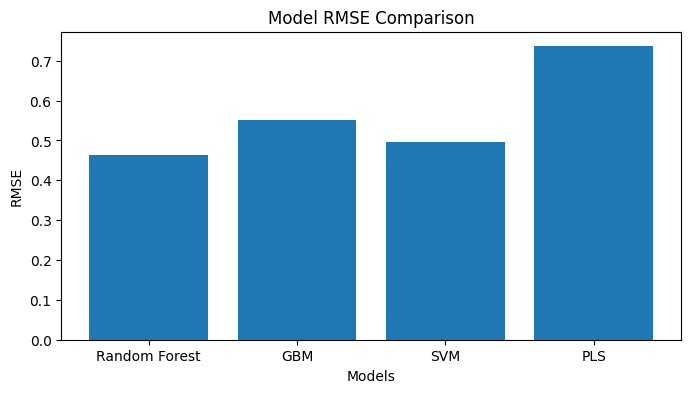

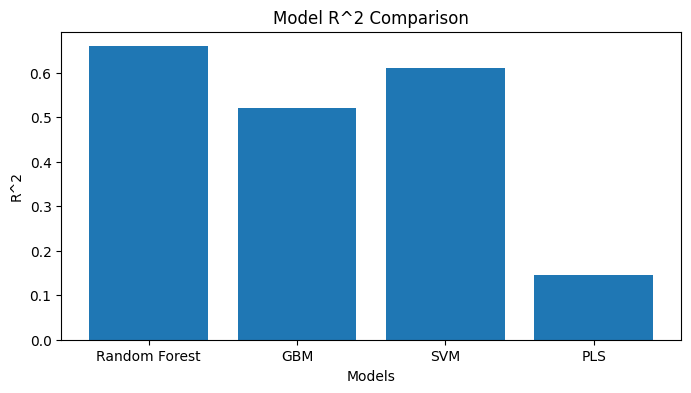

In [33]:
import matplotlib.pyplot as plt

# Plot RMSE values
plt.figure(figsize=(8, 4))
plt.bar(model_names, rmse_values)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model RMSE Comparison')
plt.show()

# Plot R^2 values
plt.figure(figsize=(8, 4))
plt.bar(model_names, r2_values)
plt.xlabel('Models')
plt.ylabel('R^2')
plt.title('Model R^2 Comparison')
plt.show()
